In [222]:
import argparse
import json
import gzip
import os
import urllib.request
import networkx as nx
from bz2 import BZ2File as bzopen
from urllib.request import urlopen
from networkx.readwrite import json_graph
from bs4 import BeautifulSoup
import datetime
from dateutil.relativedelta import *
import random
import shutil
from collections import defaultdict 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('svg')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams.update({'font.size': 8})
column_width = 3 #inches
matplotlib.font_manager._rebuild()
from networkx.drawing.nx_agraph import graphviz_layout

def update_graph(year, month, G):
    # Update graph from AS relationships data
    data_dir = 'as_relationships_data'
    fname = os.path.join(data_dir, f'{year}{month}01.as-rel.txt.bz2')
    if not os.path.exists(fname):
        return G
    with bzopen(fname, 'r') as f:
        for i, line in enumerate(f):
            line = line.decode('utf-8').strip()
            if line.startswith('#'):
                continue
            else:
                l = line.split('|')
                as1 = int(l[0])
                as2 = int(l[1])
                relationship_type = int(l[2])
                if relationship_type == -1:
                    r = 'c2p'
                elif relationship_type == 0:
                    r = 'p2p'
                else:
                    raise Exception('Invalid relationship type!')
                if (as1, as2) not in G.edges:
                    G.add_edge(as1, as2, label=r, timestamp=datetime.date(year=int(year), month=int(month), day=1))
    return G


def download_as_links_files(year, month):
    url = f'http://data.caida.org/datasets/topology/ark/ipv6/as-links/{year}/{month}'
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    links = []
    ark_monitors = set()
    for link in soup.find_all('a'):
        l = link.get('href')
        if l.startswith('cycle-aslinks.l8') and year + month in l:
            lsplit = l.split('.')
            m = lsplit[-3]
            if m not in ark_monitors:
                links.append(l)
                ark_monitors.add(m)
    data_dir = 'as_links_data'
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    out_dir = os.path.join(data_dir, year + month)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    for l in links:
        full_link = os.path.join(url, l)
        out_file = os.path.join(out_dir, l)
        if os.path.exists(out_file):
            continue
        else:
            print(f'Downloading {full_link} to {out_file}')
            try:
                urllib.request.urlretrieve(full_link, out_file)
            except:
                print('Failed to download!')


def download_as_relationships_file(year, month):
    l = f'{year}{month}01.as-rel.txt.bz2'
    full_link = f'http://data.caida.org/datasets/as-relationships/serial-1/{l}'
    data_dir = 'as_relationships_data'
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    out_file = os.path.join(data_dir, l)
    if not os.path.exists(out_file):
        print(f'Downloading {full_link} to {out_file}')
        try:
            urllib.request.urlretrieve(full_link, out_file)
        except:
            print('Failed to download!')
    

In [223]:
start_date = datetime.date(year=2008, month=12, day=1)
end_date = datetime.date(year=2020, month=4, day=1)

In [224]:
def process_as(as1, G, fname, initial=False):
    timestamp = int(fname.split('.')[3])
    if as1 not in G.nodes:
        return
#         G.add_node(as1)
    G.nodes[as1]['ipv6'] = True
    if initial:
        # Node is initially IPv6
        G.nodes[as1]['time_adopted'] = 0
        return
    else:
        # Node adopted IPv6 at this timestamp
        G.nodes[as1]['time_adopted'] = timestamp

    # Get num neighbors that have adopted IPv6
    ipv6_neighbors = 0
    for n in G.neighbors(as1):
        if G.nodes[n].get('ipv6'):
            ipv6_neighbors += 1

    G.nodes[as1]['ipv6_neighbors'] = ipv6_neighbors
    num_neighbors = len(list(G.neighbors(as1)))
    G.nodes[as1]['num_neighbors'] = num_neighbors

In [225]:
def run_analysis(start_date, end_date):
    # Create graph from AS relationships
    G = nx.Graph()

    cur_date = start_date
    initial = True
    ipv6_nodes = set() # Set of all nodes that have adopted IPv6

    while cur_date < end_date:
        cur_month = cur_date.strftime('%m')
        cur_year = cur_date.strftime('%Y')
        print(f'{cur_month}/{cur_year}')

        download_as_links_files(cur_year, cur_month)
        download_as_relationships_file(cur_year, cur_month)

        G = update_graph(cur_year, cur_month, G)
        print(f'G # nodes: {len(G.nodes)}')
        print(f'G # edges: {len(G.edges)}')

        folder = os.path.join('as_links_data', cur_year + cur_month)
        fnames = sorted(os.listdir(folder))

        for fname in fnames:
            if not fname.endswith('.gz'):
                continue
            with gzip.open(os.path.join(folder, fname), 'r') as f:
                for i, line in enumerate(f):
                    line = line.decode('utf-8').strip()
                    if line.startswith('D') or line.startswith('I'):
                        line = line.split('\t')
                        type_ = line[0]
                        as1_list = line[1].split(',')
                        as2_list = line[2].split(',')
                        for as1 in as1_list:
                            as1 = int(as1)
                            if as1 not in ipv6_nodes: # Newly adopted IPv6
                                ipv6_nodes.add(as1)
                                process_as(as1, G, fname, initial)
                            for as2 in as2_list:
                                as2 = int(as2)
                                if as2 not in ipv6_nodes: # Newly adopted IPv6
                                    ipv6_nodes.add(as2)
                                    process_as(as2, G, fname, initial)
    #                             if (as1, as2) not in G.edges:
    #                                 print(as1, as2)
    #                                 G.add_edge(as1, as2)
            initial = False

        print(len(ipv6_nodes))
        cur_date += relativedelta(months=+1)
    return G

In [226]:
G = run_analysis(start_date, end_date)

12/2008
G # nodes: 30404
G # edges: 85126
461
01/2009
G # nodes: 30802
G # edges: 90171
510
02/2009
G # nodes: 31293
G # edges: 94518
536
03/2009
G # nodes: 31693
G # edges: 98170
556
04/2009
G # nodes: 32134
G # edges: 100853
574
05/2009
G # nodes: 32501
G # edges: 103646
593
06/2009
G # nodes: 32910
G # edges: 107305
618
07/2009
G # nodes: 33286
G # edges: 110702
621
08/2009
G # nodes: 33663
G # edges: 113716
649
09/2009
G # nodes: 34047
G # edges: 116777
656
10/2009
G # nodes: 34420
G # edges: 119478
669
11/2009
G # nodes: 34889
G # edges: 122630
804
12/2009
G # nodes: 35328
G # edges: 125551
825
01/2010
G # nodes: 35666
G # edges: 127644
845
02/2010
G # nodes: 36046
G # edges: 130193
855
03/2010
G # nodes: 36432
G # edges: 132936
869
04/2010
G # nodes: 36869
G # edges: 135689
876
05/2010
G # nodes: 37285
G # edges: 138873
889
06/2010
G # nodes: 37675
G # edges: 142091
902
07/2010
G # nodes: 38024
G # edges: 145210
928
08/2010
G # nodes: 38425
G # edges: 147737
1098
09/2010
G # node

Failed to download!
G # nodes: 53556
G # edges: 309629
5742
03/2014
Failed to download!
G # nodes: 53556
G # edges: 309629
5789
04/2014


G # nodes: 54119
G # edges: 323372
5829
05/2014


Failed to download!
G # nodes: 54119
G # edges: 323372
5862
06/2014


G # nodes: 54445
G # edges: 329478
6381
07/2014


G # nodes: 54643
G # edges: 333986
6480
08/2014


G # nodes: 54805
G # edges: 337842
6518
09/2014


G # nodes: 54997
G # edges: 342115
6577
10/2014
G # nodes: 55158
G # edges: 345861
6612
11/2014


G # nodes: 55343
G # edges: 350489
6652
12/2014


G # nodes: 55510
G # edges: 355321
7337
01/2015


G # nodes: 55644
G # edges: 359327
7388
02/2015


G # nodes: 58677
G # edges: 373449
7407
03/2015
Failed to download!
G # nodes: 58677
G # edges: 373449
7484
04/2015


Failed to download!
G # nodes: 58677
G # edges: 373449
7536
05/2015


G # nodes: 59819
G # edges: 386793
7596
06/2015


G # nodes: 60263
G # edges: 393062
7615
07/2015


G # nodes: 60672
G # edges: 398047
7679
08/2015


G # nodes: 61079
G # edges: 403782
7740
09/2015


G # nodes: 61499
G # edges: 410967
7819
10/2015


G # nodes: 61890
G # edges: 415898
7869
11/2015


G # nodes: 62354
G # edges: 421694
7910
12/2015


G # nodes: 62786
G # edges: 428193
7960
01/2016


G # nodes: 63131
G # edges: 435350
7993
02/2016


G # nodes: 63574
G # edges: 444765
8049
03/2016


G # nodes: 63998
G # edges: 454562
8093
04/2016


G # nodes: 64399
G # edges: 461654
8148
05/2016


G # nodes: 64809
G # edges: 468704
9643
06/2016


G # nodes: 65248
G # edges: 482752
9736
07/2016


G # nodes: 65681
G # edges: 491297
9822
08/2016


G # nodes: 66095
G # edges: 503375
9904
09/2016


G # nodes: 66521
G # edges: 508838
10435
10/2016


G # nodes: 66919
G # edges: 514203
10607
11/2016


G # nodes: 67312
G # edges: 520358
10705
12/2016


G # nodes: 67714
G # edges: 526998
10788
01/2017


G # nodes: 68077
G # edges: 533575
10863
02/2017


G # nodes: 68461
G # edges: 539900
11285
03/2017


G # nodes: 68848
G # edges: 549260
11478
04/2017


G # nodes: 69288
G # edges: 557758
11672
05/2017


G # nodes: 69723
G # edges: 565802
11808
06/2017


G # nodes: 70179
G # edges: 572908
12097
07/2017


G # nodes: 70634
G # edges: 578973
12211
08/2017


G # nodes: 71067
G # edges: 586303
12611
09/2017


Failed to download!
G # nodes: 71481
G # edges: 593801
12725
10/2017


G # nodes: 71926
G # edges: 603752
12971
11/2017


G # nodes: 72333
G # edges: 613000
13143
12/2017


G # nodes: 72760
G # edges: 619345
13392
01/2018


G # nodes: 73104
G # edges: 625377
13540
02/2018


G # nodes: 73485
G # edges: 632836
13787
03/2018


G # nodes: 73832
G # edges: 665566
13850
04/2018


G # nodes: 74203
G # edges: 679804
13885
05/2018


G # nodes: 74639
G # edges: 696017
14283
06/2018


G # nodes: 75059
G # edges: 707119
14420
07/2018


G # nodes: 75444
G # edges: 720578
14729
08/2018


G # nodes: 75843
G # edges: 730446
14992
09/2018


G # nodes: 76262
G # edges: 749505
15222
10/2018


G # nodes: 76691
G # edges: 763088
15469
11/2018


G # nodes: 77109
G # edges: 774594
15550
12/2018


G # nodes: 77561
G # edges: 785927
15776
01/2019


G # nodes: 77894
G # edges: 794469
15946
02/2019


G # nodes: 78294
G # edges: 804651
16362
03/2019


G # nodes: 78688
G # edges: 814061
16507
04/2019


G # nodes: 79162
G # edges: 832354
16592
05/2019


G # nodes: 79598
G # edges: 839865
16939
06/2019


G # nodes: 80064
G # edges: 851034
17223
07/2019


G # nodes: 80546
G # edges: 862812
17422
08/2019


G # nodes: 80986
G # edges: 875102
17661
09/2019


G # nodes: 81481
G # edges: 887280
18116
10/2019


G # nodes: 81984
G # edges: 899486
18208
11/2019


G # nodes: 82412
G # edges: 913615
18615
12/2019


G # nodes: 82918
G # edges: 926556
18853
01/2020


G # nodes: 83345
G # edges: 943788
19193
02/2020


Failed to download!
G # nodes: 83345
G # edges: 943788
19462
03/2020


Failed to download!
G # nodes: 83345
G # edges: 943788
19637


In [227]:
initial_ipv6 = [i for i in G.nodes if G.nodes[i].get('time_adopted') == 0]
print(len(initial_ipv6))
ipv6_nodes = [n for n in G.nodes if G.nodes[n].get('ipv6')]
print(len(ipv6_nodes))

380
16511


In [228]:
def calculate_cascade_size(node, seen_nodes):
    time_adopted = G.nodes[node]['time_adopted']
    cascade_size = 1
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] > time_adopted and neighbor not in seen_nodes:
#             print(node, time_adopted, neighbor, G.nodes[neighbor]['time_adopted'])
            seen_nodes.add(node)
            cascade_size += calculate_cascade_size(neighbor, seen_nodes)
    return cascade_size

def calculate_cascade_depth(node, depth, seen_nodes):
    time_adopted = G.nodes[node]['time_adopted']
#     print('node', node)
#     print('depth', depth)
    max_depth = 0
    max_neighbor = 0
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] > time_adopted and neighbor not in seen_nodes:
#             print('influence', neighbor)
            seen_nodes.add(neighbor)
            neighbor_depth = calculate_cascade_depth(neighbor, depth + 1, seen_nodes)
#             print(neighbor_depth, max_depth)
            if neighbor_depth > max_depth:
                max_depth = neighbor_depth
                max_neighbor = neighbor
    return max_depth + 1

def calculate_num_ipv6_influencers(node):
    num_ipv6 = 0
    time_adopted = G.nodes[node]['time_adopted']
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] < time_adopted:
            num_ipv6 += 1
    return num_ipv6

def calculate_frac_ipv6_influencers(node):
    num_ipv6 = 0
    total = 0
    time_adopted = G.nodes[node]['time_adopted']
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] < time_adopted:
            num_ipv6 += 1
        total += 1
    if total == 0:
        return 0
    return num_ipv6 / float(total)







In [229]:
def plot_histogram(l, fname, title, bins):
    fig, axs = plt.subplots(1, 1, figsize=(3.25, 2.25))
    plt.hist(l, bins=bins)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

In [230]:
num_ipv6_influencers = [calculate_num_ipv6_influencers(node) for node in set(ipv6_nodes) - set(initial_ipv6)]
frac_ipv6_influencers = [calculate_frac_ipv6_influencers(node) for node in set(ipv6_nodes) - set(initial_ipv6)]

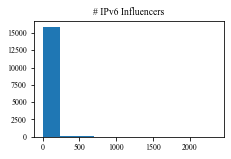

In [234]:
plot_histogram(num_ipv6_influencers, 'figures/num_ipv6_influencers.pdf', '# IPv6 Influencers', 10)

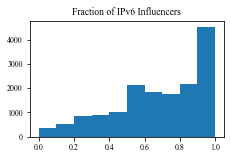

In [235]:
plot_histogram(frac_ipv6_influencers, 'figures/frac_ipv6_influencers.pdf', 'Fraction of IPv6 Influencers', 10)

In [233]:
cascade_sizes = []
cascade_depths = []
cascade_size_dict = {}
cascade_depth_dict = {}
cascade_size_small = []
for node in ipv6_nodes:
    cascade_size = calculate_cascade_size(node, set())
    cascade_depth = calculate_cascade_depth(node, 0, set())
    cascade_depths.append(cascade_depth)
    cascade_sizes.append(cascade_size)
    if cascade_size < 50 and cascade_depth > 3:
        cascade_size_small.append(node)
    cascade_size_dict[cascade_size] = node
    cascade_depth_dict[cascade_depth] = node

KeyboardInterrupt: 

In [236]:
cascade_sizes

[56711,
 74134,
 105928,
 53803,
 66923,
 3,
 74214,
 9397,
 106032,
 110416,
 105905,
 111125,
 1,
 110384,
 1,
 8022,
 2627,
 2625,
 1,
 110714,
 71356,
 113905,
 38,
 88421,
 1,
 110368,
 110946,
 73531,
 48410,
 111628,
 110838,
 74631,
 110710,
 108168,
 110529,
 65670,
 111481,
 106141,
 111124,
 111141,
 103145,
 92838,
 110910,
 111321,
 101409,
 73058,
 110683,
 33125,
 65620,
 79940,
 88427,
 110969,
 110911,
 110755,
 110708,
 111550,
 62501,
 111319,
 74275,
 111109,
 109105,
 108438,
 94366,
 109617,
 110628,
 111262,
 111801,
 111203,
 104926,
 14,
 98117,
 110516,
 39650,
 73426,
 77783,
 92830,
 111868,
 111782,
 111608,
 720,
 110948,
 110784,
 63149,
 93739,
 111721,
 32368,
 110859,
 111771,
 111158,
 33236,
 108181,
 97598,
 111542,
 43825,
 107950,
 89034,
 100944,
 33301,
 1,
 39788,
 111609,
 1,
 111227,
 104050,
 111382,
 18325,
 81563,
 1,
 100694,
 1,
 3,
 1,
 140,
 1,
 1,
 1,
 6505,
 105850,
 110362,
 722,
 100844,
 73,
 2,
 22209,
 1,
 1707,
 1708,
 1,
 1063

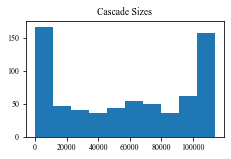

In [237]:
plot_histogram(cascade_sizes, 'figures/cascade_sizes.pdf', 'Cascade Sizes', 10) 

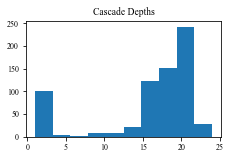

In [238]:
plot_histogram(cascade_depths, 'figures/cascade_depths.pdf', 'Cascade Depths', 10) 

In [47]:
sorted(cascade_depths, reverse=True)[0:10]

[10, 10, 9, 9, 9, 9, 9, 9, 9, 9]

In [49]:
cascade_depth_dict[9]

204418

In [60]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [183]:
def build_graph(node, seen_nodes, c_G):
    time_adopted = G.nodes[node]['time_adopted']
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] > time_adopted:
            c_G.add_edge(node, neighbor)
            labels[neighbor] = datetime.datetime.utcfromtimestamp(G.nodes[neighbor]['time_adopted']).strftime('%Y-%m-%d %H:%M:%S')
            if neighbor not in seen_nodes:
                seen_nodes.add(neighbor)
                c_G = build_graph(neighbor, seen_nodes, c_G)
    return c_G

def draw_graph(root_node):
    c_G = build_graph(root_node, set(), nx.DiGraph())
    time_adopted_set = set([0])
    for node in c_G.nodes:
        time_adopted_set.add(G.nodes[node]['time_adopted'])
    time_adopted_list = sorted(list(time_adopted_set))
    node_colors = range(len(time_adopted_list))
    node_color_list = []
    labels = {}
    for node in c_G.nodes:
        labels[node] = time_adopted_list.index(G.nodes[node]['time_adopted'])
        node_color_list.append(node_colors[time_adopted_list.index(G.nodes[node]['time_adopted'])])
    pos=graphviz_layout(c_G, prog='dot')

    nx.draw(c_G, pos=pos, node_color=node_color_list, cmap=plt.cm.Blues, node_size=45, arrow_size=4, width=0.5)

def draw_graphs(root_nodes, fname):  
    print(root_nodes)
    plt.subplot(231)
    draw_graph(root_nodes[0])
    
    plt.subplot(232)
    draw_graph(root_nodes[1])
    
    plt.subplot(233)
    draw_graph(root_nodes[2])
    
    plt.subplot(234)
    draw_graph(root_nodes[3])
    
    plt.subplot(235)
    draw_graph(root_nodes[4])
    
    plt.subplot(236)
    draw_graph(root_nodes[5])


    plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

[44297, 7018, 51297, 57111, 46208, 5555]


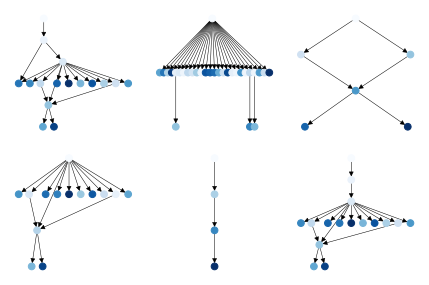

In [184]:
draw_graphs([44297, 7018, random.choice(cascade_size_small), random.choice(cascade_size_small), random.choice(cascade_size_small), random.choice(cascade_size_small)], 'figures/cascade_examples.pdf')

In [166]:
print(len(list(G.neighbors(10010))))

54


In [113]:
node = random.choice(ipv6_nodes)
print(node)
print(G.nodes[node])

63414
{'ipv6': True, 'time_adopted': 0}


In [114]:
for n in G.neighbors(node):
    print(G.nodes[n])

{'ipv6': True, 'time_adopted': 0}
{}


In [37]:
avg_fraction = 0
count = 0
for n in ipv6_nodes:
    node = G.nodes[n]
    if node['time_adopted'] > 0 and node['num_neighbors'] > 0:
        avg_fraction += float(node['ipv6_neighbors']) / node['num_neighbors']
        count += 1
print(avg_fraction/float(count))

0.7708165867754263


In [85]:
(3549, 1) in G.edges

True